In [1]:
from typing import Callable

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.lax as lax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jaxtyping import Array, Float  # https://github.com/google/jaxtyping
import brainunit as u

jax.config.update("jax_enable_x64", True)

In [2]:
# Represents the interval [x0, x_final] discretised into n equally-spaced points.
class SpatialDiscretisation(eqx.Module):
    x0: float = eqx.field(static=True)
    x_final: float = eqx.field(static=True)
    vals: Float[Array, "n"]

    @classmethod
    def discretise_fn(cls, x0: float, x_final: float, n: int, fn: Callable):
        if n < 2:
            raise ValueError("Must discretise [x0, x_final] into at least two points")
        vals = jax.vmap(fn)(u.math.linspace(x0,x_final,n))
        return cls(x0, x_final, vals)

    @property
    def δx(self):
        return (self.x_final - self.x0) / (len(self.vals) - 1)

    def binop(self, other, fn):
        if isinstance(other, SpatialDiscretisation):
            if self.x0 != other.x0 or self.x_final != other.x_final:
                raise ValueError("Mismatched spatial discretisations")
            other = other.vals
        return SpatialDiscretisation(self.x0, self.x_final, fn(self.vals, other))

    def __add__(self, other):
        return self.binop(other, lambda x, y: x + y)

    def __mul__(self, other):
        return self.binop(other, lambda x, y: x * y)

    def __radd__(self, other):
        return self.binop(other, lambda x, y: y + x)

    def __rmul__(self, other):
        return self.binop(other, lambda x, y: y * x)

    def __sub__(self, other):
        return self.binop(other, lambda x, y: x - y)

    def __rsub__(self, other):
        return self.binop(other, lambda x, y: y - x)
    
    def __truediv__(self, other):
        return self.binop(other, lambda x, y: x / y)


def laplacian(y: SpatialDiscretisation) -> SpatialDiscretisation:
    y_next = u.math.roll(y.vals, shift=1)
    y_prev = u.math.roll(y.vals, shift=-1)
        
    Δy = (y_next - 2 * y.vals + y_prev) / (y.δx**2)

    # Dirichlet boundary condition
    Δy = Δy.at[0].set(0 /(u.meter * u.second))
    Δy = Δy.at[-1].set(0/(u.meter * u.second))
    return SpatialDiscretisation(y.x0, y.x_final, Δy)

First let's try solving this semidiscretisation directly, as a system of ODEs.

In [3]:
# Problem
def vector_field(t, y, args):
    return laplacian(y) * 2e-4 * (u.meter)**2 / u.second 


term = diffrax.ODETerm(vector_field)

def ic(x):
    return u.math.where(x == 1 * u.meter, 1.0 * u.meter/u.second, 0.0 * u.meter/u.second)


# Spatial discretisation
x0 = 0 * u.meter
x_final = 1 * u.meter
n = 21
y0 = SpatialDiscretisation.discretise_fn(x0, x_final, n, ic)

# Temporal discretisation
t0 = 0 * u.second
t_final = 2500 * u.second
δt = 12.5 * u.second
saveat = diffrax.SaveAt(ts=u.math.linspace(t0, t_final, 21))

# Tolerances
rtol = 1e-10
atol = 1e-10
stepsize_controller = diffrax.PIDController(
    pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol #, dtmax=12.5 * u.second
)


/var/folders/zp/x7t5tyz54s9g9bmcv3stqzlc0000gn/T/ipykernel_30290/3586489615.py:12: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return cls(x0, x_final, vals)


In [4]:
solver = diffrax.Tsit5()
sol = diffrax.diffeqsolve(
    term,
    solver,
    t0,
    t_final,
    δt,
    y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

/var/folders/zp/x7t5tyz54s9g9bmcv3stqzlc0000gn/T/ipykernel_30290/3586489615.py:56: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return SpatialDiscretisation(y.x0, y.x_final, Δy)
/var/folders/zp/x7t5tyz54s9g9bmcv3stqzlc0000gn/T/ipykernel_30290/3586489615.py:23: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return SpatialDiscretisation(self.x0, self.x_final, fn(self.vals, other))
/var/folders/zp/x7t5tyz54s9g9bmcv3stqzlc0000gn/T/ipykernel_30290/3586489615.py:56: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return SpatialDiscretisation(y.x0, y.x_final, Δy)
/var/folders/zp/x7t5tyz54s9g9bmcv3stqzlc0000gn/T/ipykernel_30290/3586489615.py:23: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return

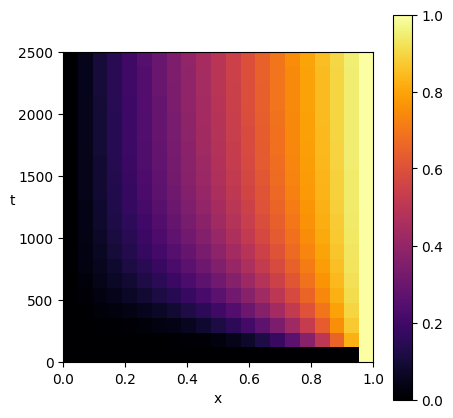

In [5]:
plt.figure(figsize=(5, 5))
plt.imshow(
    sol.ys.vals * u.second /u.meter,
    origin="lower",
    extent=(x0 /u.meter, x_final/u.meter, t0/u.second, t_final/u.second),
    aspect=(x_final/u.meter - x0/u.meter) / (t_final/u.second - t0/u.second),
    cmap="inferno",
)
plt.xlabel("x")
plt.ylabel("t", rotation=0)
plt.clim(0, 1)
plt.colorbar()
plt.show()